##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 自编码器简介

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://tensorflow.google.cn/tutorials/generative/autoencoder">     <img src="https://tensorflow.google.cn/images/tf_logo_32px.png">     在 TensorFlow.org 上查看</a>   </td>
  <td><a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/autoencoder.ipynb"><img src="https://tensorflow.google.cn/images/colab_logo_32px.png">在 Google Colab 中运行 </a></td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/autoencoder.ipynb"><img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png">在 GitHub 上查看源代码</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/generative/autoencoder.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png">下载笔记本</a></td>
</table>

本教程通过以下三个示例介绍自编码器：基础知识、图像降噪和异常检测。

自编码器是一种特殊类型的神经网络，经过训练后可将其输入复制到其输出。例如，给定一个手写数字的图像，自编码器首先将图像编码为低维的潜在表示，然后将该潜在表示解码回图像。自编码器学习压缩数据，同时最大程度地减少重构误差。

要详细了解自编码器，请考虑阅读 Ian Goodfellow、Yoshua Bengio 和 Aaron Courville 撰写的[《深度学习》](https://www.deeplearningbook.org/)一书的第 14 章。

## 导入 TensorFlow 和其他库

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model

D:\Anaconda\lib\site-packages\scipy\__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


## 加载数据集

首先，您将使用 Fashion MNIST 数据集训练基本自编码器。此数据集中的每个图像均为 28x28 像素。 

In [2]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

print (x_train.shape)
print (x_test.shape)

4431872/4422102 [==============================] - 1s 0us/step
(60000, 28, 28)
(10000, 28, 28)


## 第一个示例：基本自编码器

![Basic autoencoder results](images/intro_autoencoder_result.png)

定义一个具有两个密集层的自编码器：一个将图像压缩为 64 维隐向量的 `encoder`，以及一个从隐空间重构原始图像的 `decoder`。

要定义模型，请使用 [Keras Model Subclassing API](https://tensorflow.google.cn/guide/keras/custom_layers_and_models)。


In [3]:
latent_dim = 64 

class Autoencoder(Model):
  def __init__(self, latent_dim):
    super(Autoencoder, self).__init__()
    self.latent_dim = latent_dim   
    self.encoder = tf.keras.Sequential([
      layers.Flatten(),
      layers.Dense(latent_dim, activation='relu'),
    ])
    self.decoder = tf.keras.Sequential([
      layers.Dense(784, activation='sigmoid'),
      layers.Reshape((28, 28))
    ])

  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded
  
autoencoder = Autoencoder(latent_dim) 

In [4]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

使用 `x_train` 作为输入和目标来训练模型。`encoder` 会学习将数据集从 784 个维度压缩到隐空间，而 `decoder` 将学习重构原始图像。

In [5]:
autoencoder.fit(x_train, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0238 - val_loss: 0.0130
Epoch 2/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0115 - val_loss: 0.0105
Epoch 3/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0100 - val_loss: 0.0097
Epoch 4/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0094 - val_loss: 0.0094
Epoch 5/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0092 - val_loss: 0.0092
Epoch 6/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0090 - val_loss: 0.0090
Epoch 7/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0089 - val_loss: 0.0089
Epoch 8/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0088 - val_loss: 0.0089
Epoch 9/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0088 - val_loss: 0.0088
Epoch 10/10
1875/1875 [==============================] - 3s 2ms/step - loss: 0.008

现在，模型已经训练完成，我们通过对测试集中的图像进行编码和解码来测试该模型。

In [6]:
encoded_imgs = autoencoder.encoder(x_test).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

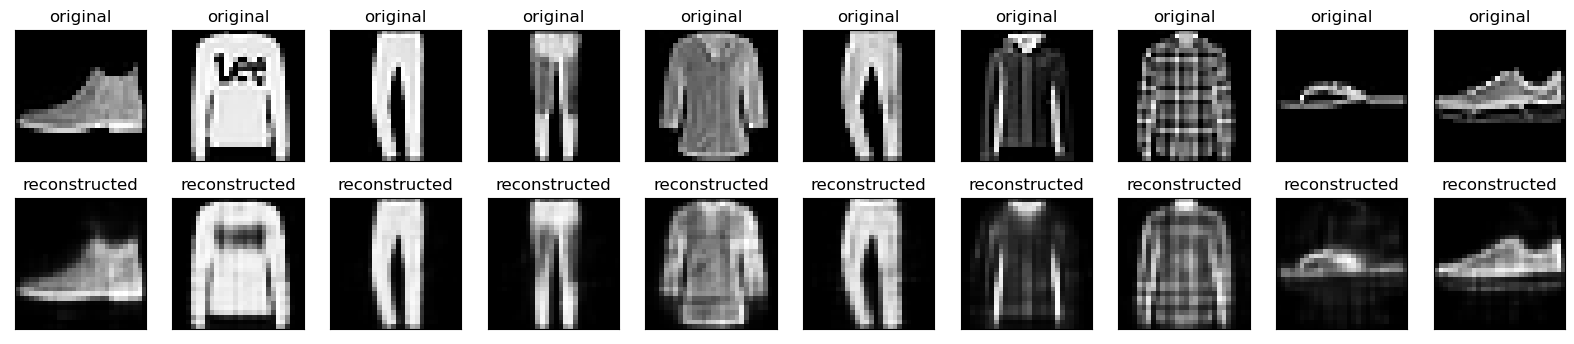

In [7]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
  # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    plt.title("original")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

  # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    plt.title("reconstructed")
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

## 第二个示例：图像降噪

![Image denoising results](https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/generative/images/image_denoise_fmnist_results.png?raw=true)

经过训练后，自编码器还可以去除图像中的噪点。在以下部分中，您将通过对每个图像应用随机噪声来创建有噪版本的 Fashion MNIST 数据集。随后，您将使用有噪图像作为输入并以原始图像作为目标来训练自编码器。

我们重新导入数据集以忽略之前所做的修改：

In [8]:
(x_train, _), (x_test, _) = fashion_mnist.load_data()

In [9]:
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = x_train[..., tf.newaxis]
x_test = x_test[..., tf.newaxis]

print(x_train.shape)

(60000, 28, 28, 1)


向图像添加随机噪声：

In [10]:
noise_factor = 0.2
x_train_noisy = x_train + noise_factor * tf.random.normal(shape=x_train.shape) 
x_test_noisy = x_test + noise_factor * tf.random.normal(shape=x_test.shape) 

x_train_noisy = tf.clip_by_value(x_train_noisy, clip_value_min=0., clip_value_max=1.)
x_test_noisy = tf.clip_by_value(x_test_noisy, clip_value_min=0., clip_value_max=1.)

绘制有噪图像：


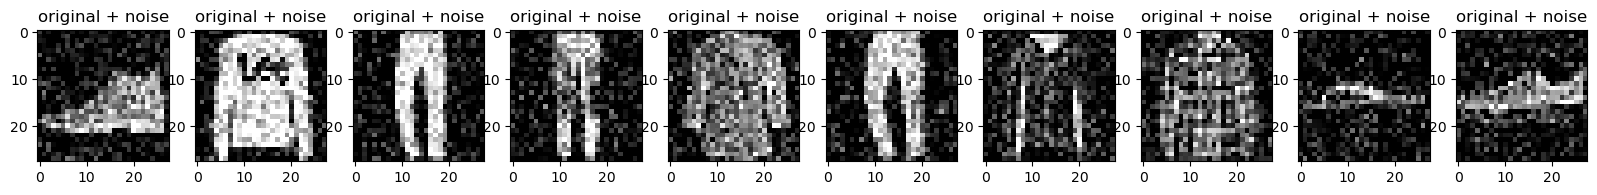

In [11]:
n = 10
plt.figure(figsize=(20, 2))
for i in range(n):
    ax = plt.subplot(1, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
plt.show()

### 定义卷积自编码器

在此示例中，您将使用 `encoder` 中的 [Conv2D](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Conv2D) 层和 `decoder` 中的 [Conv2DTranspose](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/Conv2DTranspose) 层来训练卷积自编码器。

In [12]:
class Denoise(Model):
    def __init__(self):
        super(Denoise, self).__init__()
        self.encoder = tf.keras.Sequential([
        layers.Input(shape=(28, 28, 1)),
        layers.Conv2D(16, (3, 3), activation='relu', padding='same', strides=2),
        layers.Conv2D(8, (3, 3), activation='relu', padding='same', strides=2)])

        self.decoder = tf.keras.Sequential([
        layers.Conv2DTranspose(8, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2DTranspose(16, kernel_size=3, strides=2, activation='relu', padding='same'),
        layers.Conv2D(1, kernel_size=(3, 3), activation='sigmoid', padding='same')])

    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded

autoencoder = Denoise()

In [13]:
autoencoder.compile(optimizer='adam', loss=losses.MeanSquaredError())

In [14]:
autoencoder.fit(x_train_noisy, x_train,
                epochs=10,
                shuffle=True,
                validation_data=(x_test_noisy, x_test))

Epoch 1/10
1875/1875 [==============================] - 40s 21ms/step - loss: 0.0175 - val_loss: 0.0102
Epoch 2/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0094 - val_loss: 0.0089
Epoch 3/10
1875/1875 [==============================] - 37s 20ms/step - loss: 0.0085 - val_loss: 0.0082
Epoch 4/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0079 - val_loss: 0.0078
Epoch 5/10
1875/1875 [==============================] - 36s 19ms/step - loss: 0.0076 - val_loss: 0.0075
Epoch 6/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0074 - val_loss: 0.0073
Epoch 7/10
1875/1875 [==============================] - 41s 22ms/step - loss: 0.0072 - val_loss: 0.0072
Epoch 8/10
1875/1875 [==============================] - 38s 20ms/step - loss: 0.0071 - val_loss: 0.0071
Epoch 9/10
1875/1875 [==============================] - 35s 19ms/step - loss: 0.0070 - val_loss: 0.0070
Epoch 10/10
1875/1875 [==============================] - 42s 22m

我们来看一下编码器的摘要。请注意图像是如何从 28x28 像素下采样为 7x7 像素的。

In [15]:
autoencoder.encoder.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 16)        160       
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 8)           1160      
                                                                 
Total params: 1,320
Trainable params: 1,320
Non-trainable params: 0
_________________________________________________________________


解码器将图像从 7x7 像素上采样为 28x28 像素。

In [16]:
autoencoder.decoder.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_transpose (Conv2DTra  (None, 14, 14, 8)        584       
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 28, 28, 16)       1168      
 ranspose)                                                       
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 1)         145       
                                                                 
Total params: 1,897
Trainable params: 1,897
Non-trainable params: 0
_________________________________________________________________


绘制由自编码器生成的有噪图像和去噪图像。

In [17]:
encoded_imgs = autoencoder.encoder(x_test_noisy).numpy()
decoded_imgs = autoencoder.decoder(encoded_imgs).numpy()

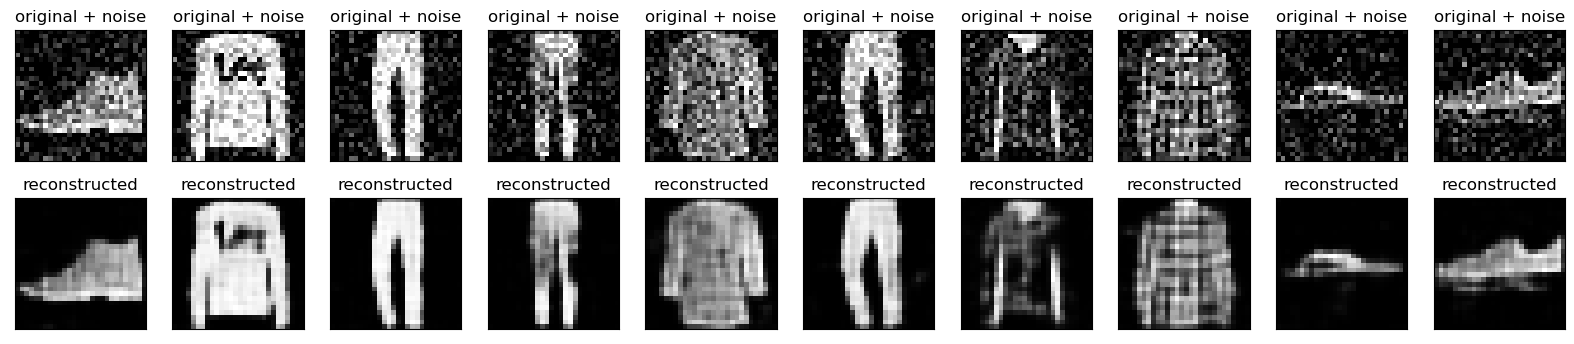

In [18]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):

    # display original + noise
    ax = plt.subplot(2, n, i + 1)
    plt.title("original + noise")
    plt.imshow(tf.squeeze(x_test_noisy[i]))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    bx = plt.subplot(2, n, i + n + 1)
    plt.title("reconstructed")
    plt.imshow(tf.squeeze(decoded_imgs[i]))
    plt.gray()
    bx.get_xaxis().set_visible(False)
    bx.get_yaxis().set_visible(False)
plt.show()

## 第三个示例：异常检测

## 概述

在此示例中，您将训练自编码器来检测 [ECG5000 数据集](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000)上的异常。此数据集包含 5,000 个[心电图](https://en.wikipedia.org/wiki/Electrocardiography)，每个心电图拥有 140 个数据点。您将使用简化版的数据集，其中每个样本都被标记为 `0`（对应于异常心律）或 `1`（对应于正常心律）。您需要关注如何识别异常心律。

注：这是一个有标签的数据集，因此您可以将其表述为一个监督学习问题。此示例的目标是说明可应用于没有可用标签的大型数据集的异常检测概念（例如，如果您有成千上万个正常心律，而只有少量异常心律）。

您将如何使用自编码器检测异常？回想一下，自编码器经过训练后可最大程度地减少重构误差。您将只基于正常心律训练自编码器，随后使用它来重构所有数据。我们的假设是，异常心律存在更高的重构误差。随后，如果重构误差超过固定阈值，则将心律分类为异常。

### 加载心电图数据

您将使用的数据集基于 [timeseriesclassification.com](http://www.timeseriesclassification.com/description.php?Dataset=ECG5000) 中的数据集。


In [20]:
# Download the dataset
dataframe = pd.read_csv('http://storage.googleapis.com/download.tensorflow.org/data/ecg.csv', header=None)
raw_data = dataframe.values
dataframe.head()

,0,1,2,3,4,5,6,7,8,9,...,131,132,133,134,135,136,137,138,139,140
0,-0.112522,-2.827204,-3.773897,-4.349751,-4.376041,-3.474986,-2.181408,-1.818286,-1.250522,-0.477492,...,0.792168,0.933541,0.796958,0.578621,0.257740,0.228077,0.123431,0.925286,0.193137,1.0
1,-1.100878,-3.996840,-4.285843,-4.506579,-4.022377,-3.234368,-1.566126,-0.992258,-0.754680,0.042321,...,0.538356,0.656881,0.787490,0.724046,0.555784,0.476333,0.773820,1.119621,-1.436250,1.0
2,-0.567088,-2.593450,-3.874230,-4.584095,-4.187449,-3.151462,-1.742940,-1.490659,-1.183580,-0.394229,...,0.886073,0.531452,0.311377,-0.021919,-0.713683,-0.532197,0.321097,0.904227,-0.421797,1.0
3,0.490473,-1.914407,-3.616364,-4.318823,-4.268016,-3.881110,-2.993280,-1.671131,-1.333884,-0.965629,...,0.350816,0.499111,0.600345,0.842069,0.952074,0.990133,1.086798,1.403011,-0.383564,1.0
4,0.800232,-0.874252,-2.384761,-3.973292,-4.338224,-3.802422,-2.534510,-1.783423,-1.594450,-0.753199,...,1.148884,0.958434,1.059025,1.371682,1.277392,0.960304,0.971020,1.614392,1.421456,1.0


In [21]:
# The last element contains the labels
labels = raw_data[:, -1]

# The other data points are the electrocadriogram data
data = raw_data[:, 0:-1]

train_data, test_data, train_labels, test_labels = train_test_split(
    data, labels, test_size=0.2, random_state=21
)

将数据归一化为 `[0,1]`。


In [22]:
min_val = tf.reduce_min(train_data)
max_val = tf.reduce_max(train_data)

train_data = (train_data - min_val) / (max_val - min_val)
test_data = (test_data - min_val) / (max_val - min_val)

train_data = tf.cast(train_data, tf.float32)
test_data = tf.cast(test_data, tf.float32)

您将仅使用正常心律训练自编码器，在此数据集中，正常心律被标记为 `1`。将正常心律与异常心律分开。

In [23]:
train_labels = train_labels.astype(bool)
test_labels = test_labels.astype(bool)

normal_train_data = train_data[train_labels]
normal_test_data = test_data[test_labels]

anomalous_train_data = train_data[~train_labels]
anomalous_test_data = test_data[~test_labels]

绘制正常的心电图。 

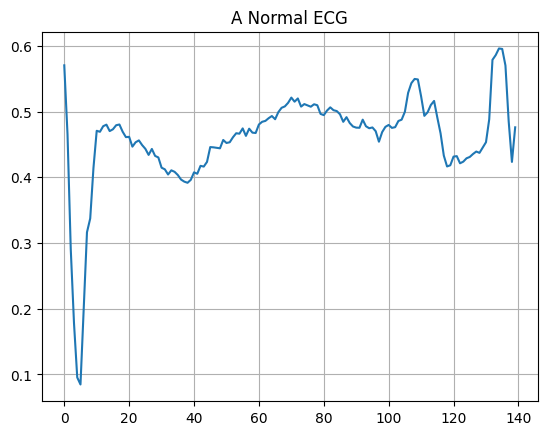

In [24]:
plt.grid()
plt.plot(np.arange(140), normal_train_data[0])
plt.title("A Normal ECG")
plt.show()

绘制异常的心电图。

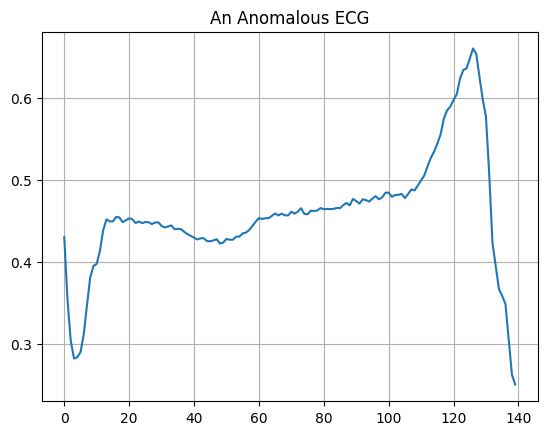

In [25]:
plt.grid()
plt.plot(np.arange(140), anomalous_train_data[0])
plt.title("An Anomalous ECG")
plt.show()

### 构建模型

In [26]:
class AnomalyDetector(Model):
  def __init__(self):
    super(AnomalyDetector, self).__init__()
    self.encoder = tf.keras.Sequential([
      layers.Dense(32, activation="relu"),
      layers.Dense(16, activation="relu"),
      layers.Dense(8, activation="relu")])
    
    self.decoder = tf.keras.Sequential([
      layers.Dense(16, activation="relu"),
      layers.Dense(32, activation="relu"),
      layers.Dense(140, activation="sigmoid")])
    
  def call(self, x):
    encoded = self.encoder(x)
    decoded = self.decoder(encoded)
    return decoded

autoencoder = AnomalyDetector()

In [27]:
autoencoder.compile(optimizer='adam', loss='mae')

请注意，自编码器仅使用正常的心电图进行训练，但使用完整的测试集进行评估。

In [28]:
history = autoencoder.fit(normal_train_data, normal_train_data, 
          epochs=20, 
          batch_size=512,
          validation_data=(test_data, test_data),
          shuffle=True)

Epoch 1/20
5/5 [==============================] - 1s 40ms/step - loss: 0.0574 - val_loss: 0.0531
Epoch 2/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0546 - val_loss: 0.0516
Epoch 3/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0509 - val_loss: 0.0496
Epoch 4/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0469 - val_loss: 0.0471
Epoch 5/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0432 - val_loss: 0.0449
Epoch 6/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0398 - val_loss: 0.0431
Epoch 7/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0368 - val_loss: 0.0416
Epoch 8/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0343 - val_loss: 0.0404
Epoch 9/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0322 - val_loss: 0.0394
Epoch 10/20
5/5 [==============================] - 0s 9ms/step - loss: 0.0305 - val_loss: 0.0386
Epoch 11/20
5/5 [=====================

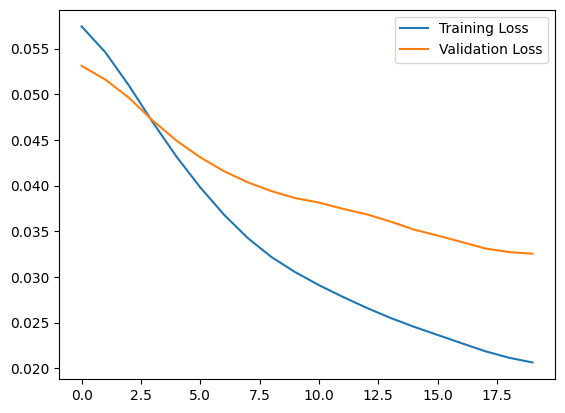

In [29]:
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.legend()

如果重构误差比正常训练样本大一个标准差，您可以快速地将心电图归类为异常。首先，我们绘制训练集中的一个正常心电图，随后绘制自编码器对其进行编码和解码后的重构以及重构误差。

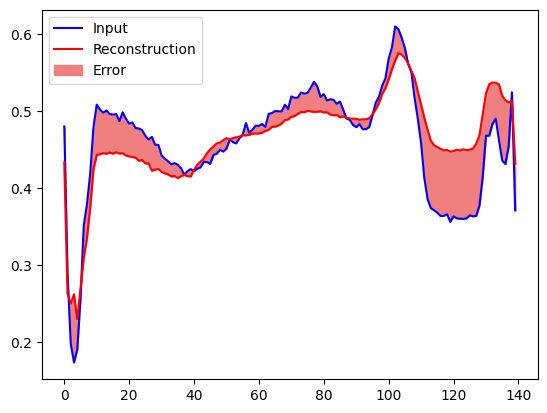

In [30]:
encoded_data = autoencoder.encoder(normal_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(normal_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], normal_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

创建一个类似的绘图，这次是一个异常的测试样本。

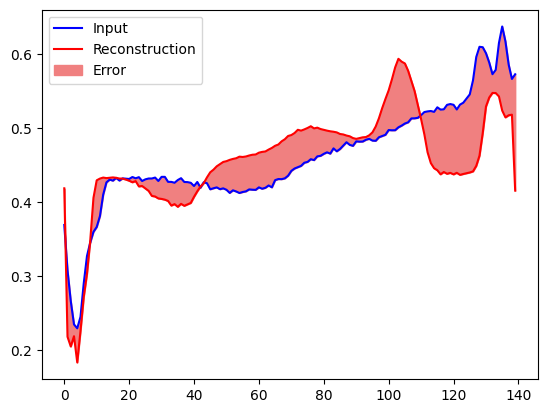

In [31]:
encoded_data = autoencoder.encoder(anomalous_test_data).numpy()
decoded_data = autoencoder.decoder(encoded_data).numpy()

plt.plot(anomalous_test_data[0], 'b')
plt.plot(decoded_data[0], 'r')
plt.fill_between(np.arange(140), decoded_data[0], anomalous_test_data[0], color='lightcoral')
plt.legend(labels=["Input", "Reconstruction", "Error"])
plt.show()

### 检测异常

通过计算重构损失是否大于固定阈值来检测异常。在本教程中，您将计算训练集中正常样本的平均误差，如果重构误差比训练集大一个标准差，则将未来的样本分类为异常。


根据训练集中的正常心电图绘制重构误差：

74/74 [==============================] - 0s 1ms/step


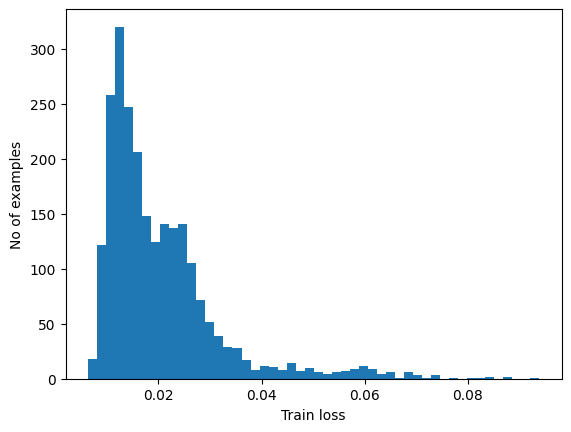

In [32]:
reconstructions = autoencoder.predict(normal_train_data)
train_loss = tf.keras.losses.mae(reconstructions, normal_train_data)

plt.hist(train_loss[None,:], bins=50)
plt.xlabel("Train loss")
plt.ylabel("No of examples")
plt.show()

选择一个比平均值高一个标准差的阈值。

In [33]:
threshold = np.mean(train_loss) + np.std(train_loss)
print("Threshold: ", threshold)

Threshold:  0.03191007


注：还有其他可用来选择阈值的策略，高于该阈值时，应将测试样本分类为异常，正确的方式将取决于您的数据集。您可以通过本教程末尾的链接了解更多信息。 

如果检查测试集中异常样本的重构误差，您会注意到大多数异常样本的重构误差都比阈值大。通过更改阈值，您可以调整分类器的[精确率](https://developers.google.com/machine-learning/glossary#precision)和[召回率](https://developers.google.com/machine-learning/glossary#recall)。 

14/14 [==============================] - 0s 1ms/step


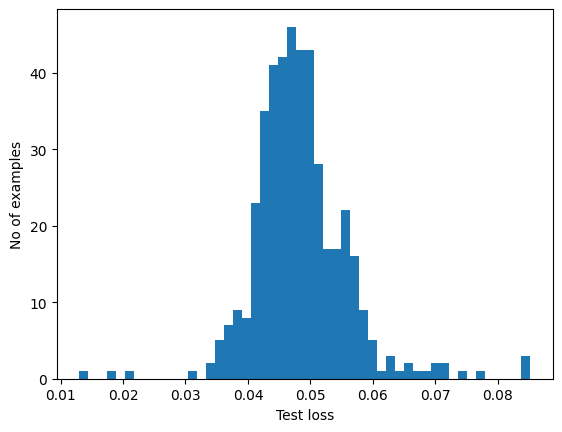

In [34]:
reconstructions = autoencoder.predict(anomalous_test_data)
test_loss = tf.keras.losses.mae(reconstructions, anomalous_test_data)

plt.hist(test_loss[None, :], bins=50)
plt.xlabel("Test loss")
plt.ylabel("No of examples")
plt.show()

如果重构误差大于阈值，则将心电图分类为异常。

In [35]:
def predict(model, data, threshold):
  reconstructions = model(data)
  loss = tf.keras.losses.mae(reconstructions, data)
  return tf.math.less(loss, threshold)

def print_stats(predictions, labels):
  print("Accuracy = {}".format(accuracy_score(labels, predictions)))
  print("Precision = {}".format(precision_score(labels, predictions)))
  print("Recall = {}".format(recall_score(labels, predictions)))

In [36]:
preds = predict(autoencoder, test_data, threshold)
print_stats(preds, test_labels)

Accuracy = 0.939
Precision = 0.9921104536489151
Recall = 0.8982142857142857


## 后续步骤

要详细了解如何使用自编码器检测异常，请查看 Victor Dibia 使用 TensorFlow.js 构建的出色[交互式示例](https://anomagram.fastforwardlabs.com/#/)。对于真实用例，您可以了解 [Airbus 如何使用 TensorFlow 检测 ISS 遥测数据中的异常](https://blog.tensorflow.org/2020/04/how-airbus-detects-anomalies-iss-telemetry-data-tfx.html)。要详细了解基础知识，请考虑阅读 François Chollet 撰写的这篇[博文](https://blog.keras.io/building-autoencoders-in-keras.html)。有关更多详细信息，请查看 Ian Goodfellow、Yoshua Bengio 和 Aaron Courville 撰写的[《深度学习》](https://www.deeplearningbook.org/)一书的第 14 章。
